In [1]:
is_skip = True

# Data params
batch_size = 1024
# batch_size = 16
min_encode_len = 60
max_encode_len = 60
pred_len = 30

valid_start_date = "2020-01-01"

# Model params
d_model = 64
nhead = 2
d_ff = 128
dropout = 0.0
num_layers = 1

# Import

In [2]:
import os
import joblib
import copy
import time

from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

from PIL import Image
from torchvision import transforms
import cv2
from transformers import ViTImageProcessor, MobileViTModel, MobileViTConfig, ViTModel, AutoImageProcessor, ViTConfig, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer
from skimage import io

device = torch.device("cuda:0")
# device = torch.device("cpu")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### Read

In [3]:
if not is_skip:
    us_holiday = holidays.US()
    
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_raw = pd.merge(df_trans, df_meta, on="article_id")

In [4]:
def preprocess(data, df_meta, is_train=True):
    data = data.copy()
    attr_cols = ["colour_group_name", "graphical_appearance_name", "product_type_name"]

   # Img_path
    data["img_path"] = data["article_id"].apply(lambda x: f'../HnM/resized_images/{x[:3]}/{x}.jpg')
    data["is_valid"] = data["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    data = data[data["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image

   # Make sales
    data = data.groupby(["t_dat", "article_id", "img_path", *attr_cols], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[data["size"] >=50]

   # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")
    data["img_path"] = data["img_path"].fillna(method="ffill")
    data = data.sort_values(["article_id", "t_dat"])

    # Deal attr_cols
    if is_train:
        color_encoder, graphic_encoder, prdc_type_encoder = LabelEncoder(), LabelEncoder(), LabelEncoder()
        color_encoder.fit(data["colour_group_name"])
        graphic_encoder.fit(data["graphical_appearance_name"])
        prdc_type_encoder.fit(data["product_type_name"])
    else: color_encoder, graphic_encoder, prdc_type_encoder = None, None, None

    # Make holidays
    us_holiday = holidays.US()
    data["holiday"] = data["t_dat"].apply(lambda x: 1 if x in us_holiday else 0)

    # Make time idx
    data["time_idx"] = data.groupby(["article_id"]).transform("cumcount")

    # Diff
    data["shift"] = data["sales"].shift(1)
    data["diff"] = data["sales"] - data["shift"]

   # Shift
    data["shift3"] = data["sales"].shift(3)
    data["shift7"] = data["sales"].shift(7)
    data["shift30"] = data["sales"].shift(30)
    data = data.dropna()

    # Accumulate sales
    data = data.sort_values(["article_id", "t_dat"]).reset_index(drop=True)
    data["accm"] = data.groupby("article_id")["sales"].cumsum()

   # Temporal information
   # Make sure the sequence start from 0
    data["day"] = data["t_dat"].dt.day - 1
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month - 1
    data["year"] = data["t_dat"].dt.year - data["t_dat"].dt.year.min()
    
   # Data to list
    data = data.groupby(["article_id", "img_path"] + attr_cols, as_index=False)[["sales", "price", "shift3", "shift7", "shift30", "time_idx", "diff", "accm"] + ["day", "dow", "month", "year", "holiday"]].agg(list)

   # Size restriction
    data["size"] = data["sales"].str.len()

   # Output
    return data, color_encoder, graphic_encoder, prdc_type_encoder

if not is_skip:
    # df_prep = df_raw[df_raw["index_name"] == "Ladieswear"]
    df_prep = df_raw.copy()

    df_train = df_prep[df_prep["t_dat"] < valid_start_date]
    df_train, color_encoder, graphic_encoder, prdc_type_encoder = preprocess(df_train, df_meta)
    df_train.to_parquet("df_train.pq")
    joblib.dump(color_encoder, "color_encoder.pkl")
    joblib.dump(graphic_encoder, "graphic_encoder.pkl")
    joblib.dump(prdc_type_encoder, "prdc_type_encoder.pkl")

    df_valid = df_prep[df_prep["t_dat"] >= valid_start_date]
    df_valid, _, _, _ = preprocess(df_valid, df_meta)
    df_valid.to_parquet("df_valid.pq")

### Dataset

In [5]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")
df_train = df_train[df_train["size"] >= min_encode_len+pred_len]
df_valid = df_valid[df_valid["size"] >= min_encode_len+pred_len]

encoder_li = {
    "color": joblib.load("color_encoder.pkl"),
    "graphic": joblib.load("graphic_encoder.pkl"),
    "prdc_type": joblib.load("prdc_type_encoder.pkl")
}

is_skip = False

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, min_encode_len, max_encode_len, pred_len, encoder_li):
        self.transform = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
        self.min_encode_len, self.max_encode_len, self.pred_len, self.encoder_li = min_encode_len, max_encode_len, pred_len, encoder_li

        # Data
        self.time_idx = data["time_idx"].values
        self.sales = data[["sales", "shift3", "shift7", "shift30", "price", "diff", "accm"]].values
        self.day, self.dow, self.month, self.year, self.holiday = data["day"].values, data["dow"].values, data["month"].values, data["year"].values, data["holiday"].values
        self.img = data["img_path"].values

        self.color =  data["colour_group_name"].values
        self.graphic = data["graphical_appearance_name"].values
        self.prdc_type = data["product_type_name"].values
    
    def __len__(self):
        return len(self.time_idx)

    def __getitem__(self, idx):
        # Slicing
        time_idx = self.time_idx[idx]
        sales_original = np.array([i for i in self.sales[idx]]).T
        sales = np.array([i for i in self.sales[idx]]).T
        day, dow, month, year, holiday = self.day[idx], self.dow[idx], self.month[idx], self.year[idx], self.holiday[idx]
        img = self.img[idx]
        color = self.color[idx]
        graphic = self.graphic[idx]
        prdc_type = self.prdc_type[idx]

        # Scale & Encode
        scaler = StandardScaler()
        sales = scaler.fit_transform(sales)

        # Finalize
        encode_idx, pred_idx = self.get_idx(time_idx.shape[-1])
        
        hist_input = np.concatenate([time_idx.reshape(-1,1), sales], axis=-1)[encode_idx]
        pred_input = time_idx[pred_idx]
        day_input = day[np.concatenate([encode_idx, pred_idx])]
        dow_input = dow[np.concatenate([encode_idx, pred_idx])]
        month_input = month[np.concatenate([encode_idx, pred_idx])]
        year_input = year[np.concatenate([encode_idx, pred_idx])]
        holiday_input = holiday[np.concatenate([encode_idx, pred_idx])]

        y = sales[np.concatenate([encode_idx, pred_idx])][:, 0]
        sales_original = sales_original[np.concatenate([encode_idx, pred_idx])]
        
        # Deal image
        img_raw = Image.open(img).convert("RGB")
        img_input = transform(img_raw, return_tensors="pt", train=False)["pixel_values"].squeeze(0)

        # Deal attribute
        color_input = self.encoder_li["color"].transform(np.array([color]))
        graphic_input = self.encoder_li["graphic"].transform(np.array([graphic]))
        prdc_type_input = self.encoder_li["prdc_type"].transform(np.array([prdc_type]))
        
        return {"hist_input":torch.Tensor(hist_input), "pred_input":torch.Tensor(pred_input), 
                "day_input":torch.IntTensor(day_input), "dow_input":torch.IntTensor(dow_input), "month_input":torch.IntTensor(month_input), "holiday_input":torch.IntTensor(holiday_input),
                "img_raw":img_raw, "img_input":img_input,
                "color_input":torch.IntTensor(color_input), "graphic_input":torch.IntTensor(graphic_input), "prdc_type_input":torch.IntTensor(prdc_type_input),
                "encode_idx":torch.IntTensor(encode_idx), "pred_idx":torch.IntTensor(pred_idx),
                "y":torch.Tensor(y), "sales_original":torch.Tensor(sales_original)}

    def get_idx(self, seq_len):
        while True:
            encode_len = np.random.randint(self.min_encode_len, self.max_encode_len+1)
            pred_len = self.pred_len
            if encode_len + pred_len <= seq_len:
                break
        assert seq_len >= encode_len + pred_len
        
        idx = np.arange(seq_len)
        encode_idx = idx[:encode_len]
        pred_idx = idx[encode_len:encode_len+pred_len]
        
        return encode_idx, pred_idx

def collate_fn(batch_li):
    hist_input = [batch["hist_input"] for batch in batch_li]
    pred_input = [batch["pred_input"] for batch in batch_li]
    day_input = [batch["day_input"] for batch in batch_li]
    dow_input = [batch["dow_input"] for batch in batch_li]
    month_input = [batch["month_input"] for batch in batch_li]
    holiday_input = [batch["holiday_input"] for batch in batch_li]
    img_raw = [batch["img_raw"] for batch in batch_li]
    img_input = [batch["img_input"] for batch in batch_li]
    color_input = [batch["color_input"] for batch in batch_li]
    graphic_input = [batch["graphic_input"] for batch in batch_li]
    prdc_type_input = [batch["prdc_type_input"] for batch in batch_li]
    
    y = [batch["y"] for batch in batch_li]
    sales_original = [batch["sales_original"] for batch in batch_li]
    
    encode_idx = [batch["encode_idx"] for batch in batch_li]
    pred_idx = [batch["pred_idx"] for batch in batch_li]

    return {"hist_input": torch.stack(hist_input), "pred_input": torch.stack(pred_input),
            "day_input":torch.stack(day_input), "dow_input":torch.stack(dow_input), "month_input":torch.stack(month_input), "holiday_input":torch.stack(holiday_input),
            "img_raw":img_raw, "img_input":torch.stack(img_input),
            "color_input":torch.stack(color_input), "graphic_input":torch.stack(graphic_input), "prdc_type_input":torch.stack(prdc_type_input),
            "encode_idx":torch.stack(encode_idx), "pred_idx":torch.stack(pred_idx),
            "y":torch.stack(y), "sales_original":torch.stack(sales_original)
            }


transform = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
train_dataset = Dataset(df_train, min_encode_len, max_encode_len, pred_len, encoder_li)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True, num_workers=8, prefetch_factor=4)

# valid = Dataset(df_valid)
# valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=2, shuffle=False)

for data in train_dataloader:
    print(f"hist_input:", data["hist_input"].shape)
    print(f"pred_input:", data["pred_input"].shape)
    print(f"day_input:", data["day_input"].shape)
    print(f"img_input:", data["img_input"].shape)
    print(f"color_input", data["color_input"].shape)
    print(f"y", data["y"].shape)
    break

hist_input: torch.Size([1024, 60, 8])
pred_input: torch.Size([1024, 30])
day_input: torch.Size([1024, 90])
img_input: torch.Size([1024, 3, 224, 224])
color_input torch.Size([1024, 1])
y torch.Size([1024, 90])


# Architecture

### Helper

In [6]:
from torch.nn import functional as F

def _generate_square_subsequent_mask(sz, device, dtype):
    return torch.triu(
        torch.full((sz, sz), float('-inf'), dtype=dtype, device=device),
        diagonal=1,
    )

def _get_seq_len(src, batch_first):
    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

def _detect_is_causal_mask(mask, is_causal=None,size=None):
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal

class FeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, activation):
        super().__init__()
        self.linear1 = torch.nn.Linear(d_model, d_ff)
        self.linear2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout()

        if activation == "relu":
            self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout(x)

class DecoderLayer(torch.nn.TransformerDecoderLayer):
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=False, memory_is_causal=False):
        x = tgt
        if self.norm_first: raise
        else:
            self_attn_output, self_attn_weight = self._sa_block(x, tgt_mask, tgt_key_padding_mask, tgt_is_causal)
            x = self.norm1(x + self_attn_output)

            cross_attn_output, cross_attn_weight = self._mha_block(x, memory, memory_mask, memory_key_padding_mask, memory_is_causal)
            x = self.norm2(x + cross_attn_output)
            x = self.norm3(x + self._ff_block(x))
        return x, self_attn_weight, cross_attn_weight

    # self-attention block
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        x, self_attn_weight = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           is_causal=is_causal,
                           need_weights=True, average_attn_weights=False)
        return self.dropout1(x), self_attn_weight

    # multihead attention block
    def _mha_block(self, x, mem, attn_mask, key_padding_mask, is_causal=False):
        x, cross_attn_weight = self.multihead_attn(x, mem, mem,
                                attn_mask=attn_mask,
                                key_padding_mask=key_padding_mask,
                                is_causal=is_causal,
                                need_weights=True, average_attn_weights=False)
        return self.dropout2(x), cross_attn_weight

class Decoder(torch.nn.TransformerDecoder):
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=None, memory_is_causal=False):
        output = tgt

        seq_len = _get_seq_len(tgt, self.layers[0].self_attn.batch_first)
        tgt_is_causal = _detect_is_causal_mask(tgt_mask, tgt_is_causal, seq_len)

        for n, mod in enumerate(self.layers):
            output, self_attn_weight_, cross_attn_weight_ = mod(output, memory, tgt_mask=tgt_mask,
                                                            memory_mask=memory_mask,
                                                            tgt_key_padding_mask=tgt_key_padding_mask,
                                                            memory_key_padding_mask=memory_key_padding_mask,
                                                            tgt_is_causal=tgt_is_causal,
                                                            memory_is_causal=memory_is_causal)
            if n == 0:
                self_attn_weight, cross_attn_weight = self_attn_weight_, cross_attn_weight_

        if self.norm is not None:
            output = self.norm(output)

        return output, self_attn_weight, cross_attn_weight

class EncoderLayer(torch.nn.TransformerEncoderLayer):
    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        x = src
        attn_output, attn_weight = self._sa_block(x, src_mask, src_key_padding_mask, is_causal=is_causal)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self._ff_block(x))

        return x, attn_weight

    # self-attention block
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        x, attn_weight = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=True, is_causal=is_causal)
        return self.dropout1(x), attn_weight

class Encoder(torch.nn.TransformerEncoder):
    def forward(self, src, mask=None, src_key_padding_mask=None, is_causal=None):
       ################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(mask),
            other_name="mask",
            target_type=src.dtype
        )

        mask = F._canonical_mask(
            mask=mask,
            mask_name="mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        src_key_padding_mask_for_layers = src_key_padding_mask
        why_not_sparsity_fast_path = ''
        str_first_layer = "self.layers[0]"
        batch_first = first_layer.self_attn.batch_first
        if not hasattr(self, "use_nested_tensor"):
            why_not_sparsity_fast_path = "use_nested_tensor attribute not present"
        elif not self.use_nested_tensor:
            why_not_sparsity_fast_path = "self.use_nested_tensor (set in init) was not True"
        elif first_layer.training:
            why_not_sparsity_fast_path = f"{str_first_layer} was in training mode"
        elif not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif src_key_padding_mask is None:
            why_not_sparsity_fast_path = "src_key_padding_mask was None"
        elif (((not hasattr(self, "mask_check")) or self.mask_check)
                and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):
            why_not_sparsity_fast_path = "mask_check enabled, and src and src_key_padding_mask was not left aligned"
        elif output.is_nested:
            why_not_sparsity_fast_path = "NestedTensor input is not supported"
        elif mask is not None:
            why_not_sparsity_fast_path = "src_key_padding_mask and mask were both supplied"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"

        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                first_layer.self_attn.in_proj_weight,
                first_layer.self_attn.in_proj_bias,
                first_layer.self_attn.out_proj.weight,
                first_layer.self_attn.out_proj.bias,
                first_layer.norm1.weight,
                first_layer.norm1.bias,
                first_layer.norm2.weight,
                first_layer.norm2.bias,
                first_layer.linear1.weight,
                first_layer.linear1.bias,
                first_layer.linear2.weight,
                first_layer.linear2.bias,
            )
            _supported_device_type = ["cpu", "cuda", torch.utils.backend_registration._privateuse1_backend_name]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif src.device.type not in _supported_device_type:
                why_not_sparsity_fast_path = f"src device is neither one of {_supported_device_type}"
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if (not why_not_sparsity_fast_path) and (src_key_padding_mask is not None):
                convert_to_nested = True
                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
                src_key_padding_mask_for_layers = None

        seq_len = _get_seq_len(src, batch_first)
        is_causal = _detect_is_causal_mask(mask, is_causal, seq_len)
       ################################################################################################################

        for mod in self.layers:
            output, attn_weight = mod(output, src_mask=mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask_for_layers)

        if convert_to_nested:
            output = output.to_padded_tensor(0., src.size())

        if self.norm is not None:
            output = self.norm(output)

        return output, attn_weight

### Transformer

In [7]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout):
        super().__init__()
        # Initial input
        self.hist_lstm = torch.nn.LSTM(8, d_model, batch_first=True, dropout=dropout)
        self.pred_lstm = torch.nn.LSTM(1, d_model, batch_first=True, dropout=dropout)

        # Hist-hist attention
        self.histhist_attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)
        self.histhist_layernorm = torch.nn.LayerNorm(d_model)

        # Hist-temporal attention
        self.day_embedder = torch.nn.Embedding(365, d_model)
        self.dow_embedder = torch.nn.Embedding(7, d_model)
        self.month_embedder = torch.nn.Embedding(12, d_model)
        self.holiday_embedder = torch.nn.Embedding(2, d_model)
        self.histtemp_attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)
        self.histtemp_layernorm = torch.nn.LayerNorm(d_model)

        # Image-image attention
        config = ViTConfig(hidden_size=d_model, num_hidden_layers=num_layers, num_attention_heads=nhead, intermediate_size=d_ff, patch_size=10, encoder_stride=10)
        self.img_model = ViTModel(config)

        # Hist-image attention
        self.histimg_attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)
        self.histimg_layernorm = torch.nn.LayerNorm(d_model)

        # Fusion
        self.fusion_linear = torch.nn.Linear(d_model*2, d_model)

        # Output
        self.output_linear = torch.nn.Linear(d_model, 1)

    def forward(self, hist_input, pred_input, day_input, dow_input, month_input, holiday_input, img_input):
        # Initial input
        hist_lstm, hist_context = self.hist_lstm(hist_input)
        pred_lstm, _ = self.pred_lstm(pred_input, hist_context)
        total_lstm = torch.concat([hist_lstm, pred_lstm], dim=1)

        # Hist-hist attention
        histhist_attnoutput, histhist_attnweight = self.histhist_attn(query=total_lstm, key=total_lstm, value=total_lstm)
        histhist_attnoutput = self.histhist_layernorm(histhist_attnoutput + total_lstm)

        # Hist-temporal attention
        kind = 4
        day_input = self.day_embedder(day_input)
        dow_input = self.dow_embedder(dow_input)
        month_input = self.month_embedder(month_input)
        holiday_input = self.holiday_embedder(holiday_input)
        temporal_input = torch.stack([day_input, dow_input, month_input, holiday_input], dim=1).view(-1, day_input.shape[1]*kind, d_model)
        temporal_mask = self.get_temporal_mask(kind=kind, query_seq=total_lstm.shape[1], key_seq=day_input.shape[1])
        histtemp_attnoutput, histtemp_attnweight = self.histtemp_attn(query=histhist_attnoutput, key=temporal_input, value=temporal_input, attn_mask=temporal_mask)
        histtemp_attnoutput = self.histtemp_layernorm(histtemp_attnoutput + histhist_attnoutput)


        # Img-img_attention
        imgimg_attnoutput, _, imgimg_attnweight = self.img_model(img_input, output_attentions=True).values()
        imgimg_attnweight = imgimg_attnweight[0]

        # Hist-img attention
        histimg_attnoutput, histimg_attnweight = self.histimg_attn(query=histhist_attnoutput, key=imgimg_attnoutput, value=imgimg_attnoutput)
        histimg_attnoutput = self.histimg_layernorm(histimg_attnoutput + histhist_attnoutput)

        # Fusion
        # fusion = torch.concat([histtemp_attnoutput, histimg_attnoutput], dim=-1)
        fusion = torch.concat([histtemp_attnoutput], dim=-1)
        # fusion = self.fusion_linear(fusion)

        # Output
        output = self.output_linear(fusion)

        return output.squeeze(), histhist_attnweight, histtemp_attnweight, imgimg_attnweight, histimg_attnweight

    def get_temporal_mask(self, kind, query_seq, key_seq):
        mask = torch.zeros(query_seq, kind*key_seq).to(device) + -torch.inf
        for i in range(mask.shape[0]):
            mask[i, kind*i : kind*i+kind] = 0
        return mask
        
model = Transformer(d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
summary(model,
        data["hist_input"].to(device),
        data["pred_input"].unsqueeze(-1).to(device),
        data["day_input"].to(device), data["dow_input"].to(device), data["month_input"].to(device), data["holiday_input"].to(device),
        data["img_input"].to(device),
        show_parent_layers=True, print_summary=True)

--------------------------------------------------------------------------------------------------------------------------
   Parent Layers             Layer (type)                                     Output Shape         Param #     Tr. Param #
     Transformer                   LSTM-1     [1024, 60, 64], [1, 1024, 64], [1, 1024, 64]          18,944          18,944
     Transformer                   LSTM-2     [1024, 30, 64], [1, 1024, 64], [1, 1024, 64]          17,152          17,152
     Transformer     MultiheadAttention-3                   [1024, 90, 64], [1024, 90, 90]          16,640          16,640
     Transformer              LayerNorm-4                                   [1024, 90, 64]             128             128
     Transformer              Embedding-5                                   [1024, 90, 64]          23,360          23,360
     Transformer              Embedding-6                                   [1024, 90, 64]             448             448
     Transformer

'--------------------------------------------------------------------------------------------------------------------------\n   Parent Layers             Layer (type)                                     Output Shape         Param #     Tr. Param #\n==========================================================================================================================\n     Transformer                   LSTM-1     [1024, 60, 64], [1, 1024, 64], [1, 1024, 64]          18,944          18,944\n     Transformer                   LSTM-2     [1024, 30, 64], [1, 1024, 64], [1, 1024, 64]          17,152          17,152\n     Transformer     MultiheadAttention-3                   [1024, 90, 64], [1024, 90, 90]          16,640          16,640\n     Transformer              LayerNorm-4                                   [1024, 90, 64]             128             128\n     Transformer              Embedding-5                                   [1024, 90, 64]          23,360          23,360\n     Tr

# Train

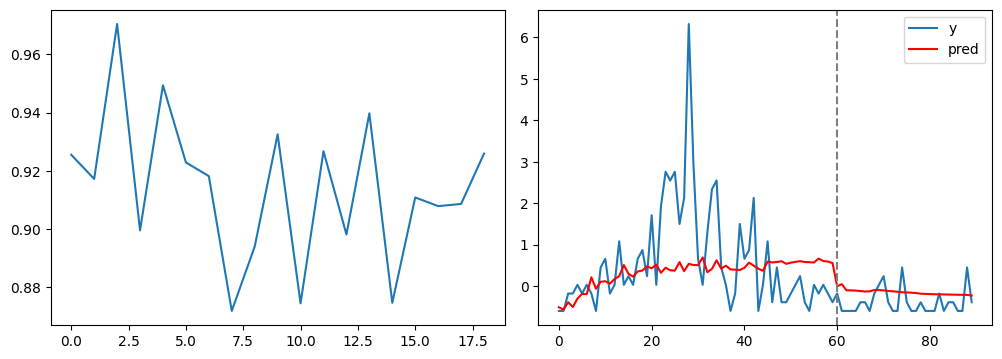

3 - loss: 0.9140868092838087, cheating_loss: 0.9140868092838087, real_loss: 0.9140868092838087, lr: 0.0009411919999999999: 100%|██████████| 19/19 [00:12<00:00,  1.48it/s]
  0%|          | 0/19 [00:00<?, ?it/s]

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
mse_loss = torch.nn.MSELoss()
mse_loss_full = torch.nn.MSELoss(reduction="none")

def output_loss_func(pred, y, y_original, encode_idx, pred_idx):
    return mse_loss(pred[:, -30:], y[:, -30:]), mse_loss(pred[:, -30:], y[:, -30:])

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li, cheating_loss_li, real_loss_li = [], [], []
    window = 100

    for n, data in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        pred, histhist_attnweight, histtemp_attnweight, imgimg_attnweight, histimg_attnweight = model(
                                                                                            data["hist_input"].to(device),
                                                                                            data["pred_input"].unsqueeze(-1).to(device),
                                                                                            data["day_input"].to(device), data["dow_input"].to(device), data["month_input"].to(device), data["holiday_input"].to(device),
                                                                                            data["img_input"].to(device),
                                                                                            )
        cheating_loss, real_loss = output_loss_func(pred, data["y"].to(device), data["sales_original"], data["encode_idx"], data["pred_idx"])
        loss = real_loss
        cheating_loss_li.append(cheating_loss.item()); real_loss_li.append(real_loss.item()); loss_li.append(loss.item())
        loss.backward()
        optimizer.step()
        pbar.set_description(f"{e} - loss: {np.mean(loss_li[-window:])}, cheating_loss: {np.mean(cheating_loss_li[-window:])}, real_loss: {np.mean(real_loss_li[-window:])}, lr: {optimizer.param_groups[0]['lr']}")

        if n % 3 == 0:
        # if n:
            plt.figure(figsize=(15,7))
            nrows, ncols = 2, 3
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, 1)
            plt.plot(loss_li[-window:])

            # Sample
            plt.subplot(nrows, ncols, 2)
            df_y = pd.DataFrame({"y":data["y"][-1]}).reset_index()
            df_pred = pd.DataFrame({"pred":pred[-1].detach().cpu().numpy()}).reset_index()
            
            df_res = pd.merge(df_y, df_pred, on="index", how="outer")

            plt.plot(df_res["y"], label="y")
            plt.plot(df_res["pred"], label="pred", color="red")
            plt.axvline(len(data["encode_idx"][-1]), linestyle="--", color="gray")
            plt.legend()

            # # Attn
            # plt.subplot(nrows, ncols, 3)
            # sns.heatmap(seqseq_attnweight[-1].mean(dim=0).detach().cpu(), cbar=False)
            # plt.title("seqseq_attnweight")

            # plt.subplot(nrows, ncols, 4)
            # sns.heatmap(seqtemporal_attnweight[-1].mean(dim=0).detach().cpu(), cbar=False)
            # plt.title("seqtemporal_attnweight")

            # plt.subplot(nrows, ncols, 5)
            # plt.imshow(data["img_raw"][-1])

            # plt.subplot(nrows, ncols, 6)
            # # mask = torch.min(seqimg_attnweight, dim=1).values
            # mask = torch.mean(seqimg_attnweight, dim=1)
            # mask = torch.mean(mask, dim=1)
            # mask = mask[-1, 1:].reshape(14,14).cpu().detach().numpy() # 28,28 or 14,14
            # mask = cv2.resize(mask / mask.max(), data["img_raw"][-1].size)[..., np.newaxis]
            # plt.imshow(mask)

            plt.tight_layout()
            plt.show()


epoch = 10
for e in range(epoch):
    train(e)
    scheduler.step()

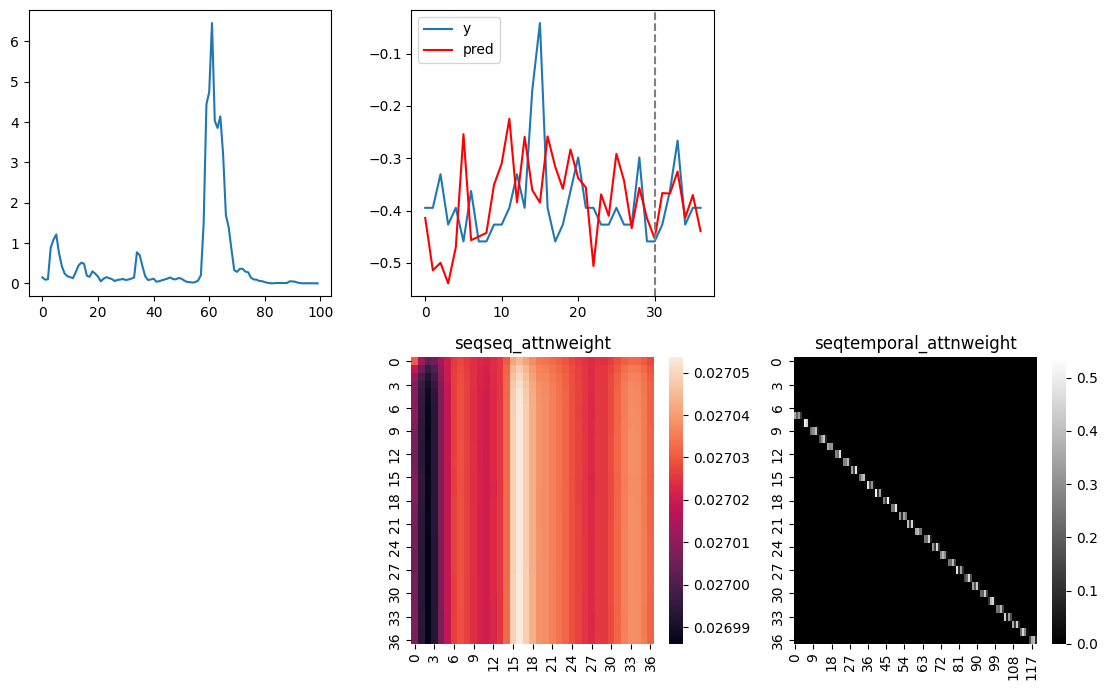

2 - loss: 0.7273393359035254, cheating_loss: 0.15648389888927342, cheating_loss: 0.7273393359035254, lr: 0.0009603999999999999:   4%|▍         | 28724/654296 [00:51<18:37, 559.59it/s]  


KeyboardInterrupt: 

In [ ]:
pbar = tqdm(valid_dataloader)
loss_li, cheating_loss_li, real_loss_li = [], [], []
window = 100
min_loss = np.inf

for n, data in enumerate(pbar):
    model.eval()
    with torch.no_grad():
        pred, seqseq_attnweight, seqtemporal_attnweight = model(
                                                                data["hist_input"].to(device),
                                                                data["pred_input"].to(device),
                                                                data["day_input"].to(device), data["dow_input"].to(device), data["month_input"].to(device), data["holiday_input"].to(device),
                                                                                )
        cheating_loss, real_loss = output_loss_func(pred, data["y"].to(device))
        loss = real_loss
        cheating_loss_li.append(cheating_loss.item()); real_loss_li.append(real_loss.item()); loss_li.append(loss.item())
        pbar.set_description(f"{e} - loss: {np.mean(loss_li[-window:])}, cheating_loss: {np.mean(cheating_loss_li[-window:])}, cheating_loss: {np.mean(real_loss_li[-window:])}, lr: {optimizer.param_groups[0]['lr']}")

        if loss < min_loss:
            min_loss = loss
            plt.figure(figsize=(15,7))
            nrows, ncols = 2, 4
            clear_output(wait=True)
            plt.subplot(nrows, ncols, 1)
            plt.plot(loss_li[-window:])

            plt.subplot(nrows, ncols, 2)
            df_y = pd.DataFrame({"y":data["y"][-1]}).reset_index()
            df_pred = pd.DataFrame({"pred":pred[-1].detach().cpu().numpy()}).reset_index()
            
            df_res = pd.merge(df_y, df_pred, on="index", how="outer")

            plt.plot(df_res["y"], label="y")
            plt.plot(df_res["pred"], label="pred", color="red")
            plt.axvline(encode_len, linestyle="--", color="gray")
            plt.legend()

            # plt.subplot(nrows, ncols, 5)
            # sns.heatmap(histhist_attnweight[-1].detach().cpu())
            # plt.title("histhist_attnweight")

            plt.subplot(nrows, ncols, 6)
            sns.heatmap(seqseq_attnweight[-1].mean(dim=0).detach().cpu())
            plt.title("seqseq_attnweight")

            plt.subplot(nrows, ncols, 7)
            sns.heatmap(seqtemporal_attnweight[-1].mean(dim=0)[-30*4:, -30*4:].detach().cpu(), cmap="gray")
            plt.title("seqtemporal_attnweight")

            # plt.subplot(nrows, ncols, 8)
            # sns.heatmap(out_hist_attn[-1].detach().cpu())
            # plt.title("out_hist_attn")

            plt.tight_layout()
            plt.show()